<a href="https://colab.research.google.com/github/ETHNHUNT/AIG_Deep_Learning/blob/main/Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Implementing a Simple Recurrent Neural Network (RNN)

## Introduction

In this project, you will design, implement, and evaluate a simple Recurrent Neural Network (RNN) from scratch. This will involve building the entire pipeline, from data preprocessing to model training and evaluation.

## Objectives

1. Set up TensorFlow or PyTorch environments. You are free to choose your preferred DL platform.
2. Use GPU for training.
3. Create a data loader and implement data preprocessing where needed.
4. Design a Convolutional Neural Network.
5. Train and evaluate your model. Make sure to clearly show loss and accuracy values. Include visualizations too.
6. Answer assessment questions.

## Dataset

You are free to choose any dataset for this project! Kaggle would be a good source to look for datasets. Below are some examples:
- Daily Minimum Temperatures in Melbourne: This dataset contains the daily minimum temperatures in Melbourne, Australia, from 1981 to 1990.
- Daily Bitcoin Prices: This dataset contains historical daily prices of Bitcoin, which can be used for time series forecasting projects.
- Text8 Dataset: This dataset consists of the first 100 million characters from Wikipedia. It's great for text generation or language modeling tasks.
- IMDB Movie Reviews: This dataset contains 50,000 movie reviews for sentiment analysis, split evenly into 25,000 training and 25,000 test sets.
- Jena Climate Dataset: This dataset records various weather attributes (temperature, pressure, humidity, etc.) every 10 minutes, making it ideal for time series analysis.
- Earthquake Aftershocks: This dataset contains seismic data, suitable for predicting aftershocks following major earthquakes.


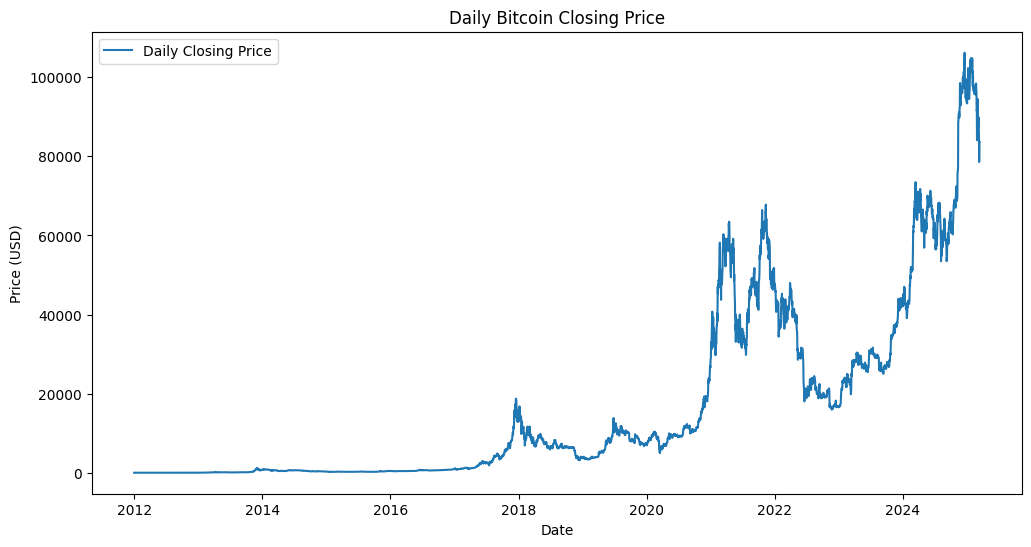

Epoch 1/30
241/241 - 4s - 17ms/step - loss: 3.1729e-04
Epoch 2/30
241/241 - 1s - 5ms/step - loss: 1.0006e-04
Epoch 3/30
241/241 - 1s - 5ms/step - loss: 1.0220e-04
Epoch 4/30
241/241 - 1s - 5ms/step - loss: 8.5837e-05
Epoch 5/30
241/241 - 1s - 5ms/step - loss: 7.8497e-05
Epoch 6/30
241/241 - 1s - 6ms/step - loss: 8.3925e-05
Epoch 7/30
241/241 - 2s - 7ms/step - loss: 8.0453e-05
Epoch 8/30
241/241 - 2s - 9ms/step - loss: 7.2016e-05
Epoch 9/30
241/241 - 1s - 5ms/step - loss: 7.4231e-05
Epoch 10/30
241/241 - 1s - 5ms/step - loss: 6.6995e-05
Epoch 11/30
241/241 - 1s - 5ms/step - loss: 6.9435e-05
Epoch 12/30
241/241 - 1s - 5ms/step - loss: 6.9447e-05
Epoch 13/30
241/241 - 1s - 5ms/step - loss: 7.1978e-05
Epoch 14/30
241/241 - 1s - 5ms/step - loss: 7.1279e-05
Epoch 15/30
241/241 - 2s - 7ms/step - loss: 6.4952e-05
Epoch 16/30
241/241 - 2s - 7ms/step - loss: 6.8878e-05
Epoch 17/30
241/241 - 2s - 9ms/step - loss: 8.0147e-05
Epoch 18/30
241/241 - 1s - 5ms/step - loss: 7.1760e-05
Epoch 19/30
241/24

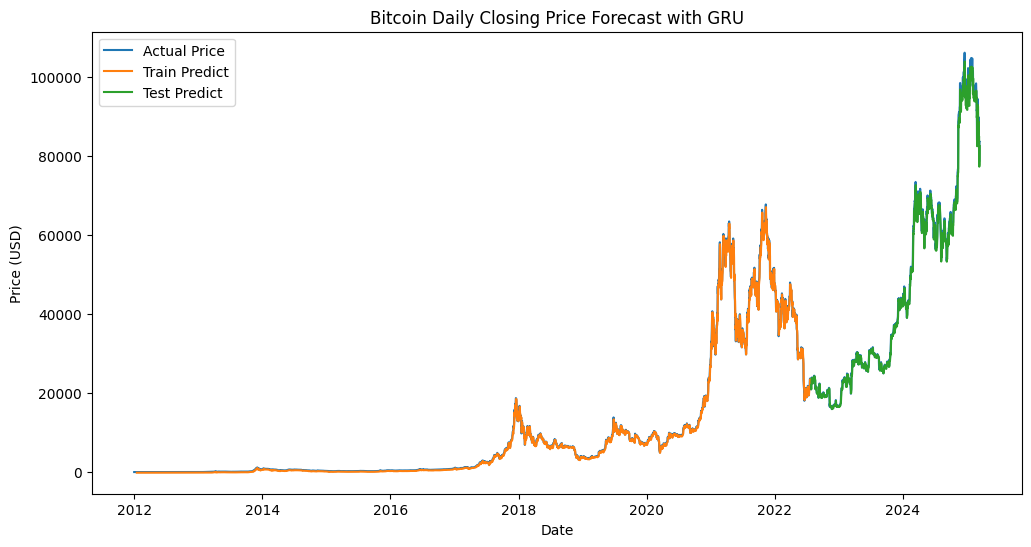

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

# 1. Load and Resample Data
# Adjust the file path as needed
df = pd.read_csv('btcusd_1-min_data.csv')

# Convert 'Timestamp' column to datetime (assuming Unix timestamp in seconds)
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df.set_index('Timestamp', inplace=True)

# Resample the one-minute data to daily frequency (using last closing price of each day)
daily = df['Close'].resample('D').last()

# Optionally drop any days with NaN values
daily.dropna(inplace=True)

# 2. Visualize the Daily Data
plt.figure(figsize=(12, 6))
plt.plot(daily, label='Daily Closing Price')
plt.title('Daily Bitcoin Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


# 3. Data Preprocessing
# Scale data to [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
daily_scaled = scaler.fit_transform(daily.values.reshape(-1, 1))

# Create sequences of length 'look_back' to predict the next day
def create_dataset(dataset, look_back=15):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        dataX.append(dataset[i : (i + look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 15
X, y = create_dataset(daily_scaled, look_back=look_back)

# Train/Test split (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape inputs for GRU: [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


# 4. Build and Train the GRU Model
model = Sequential()
model.add(Input(shape=(look_back, 1)))
model.add(GRU(100, return_sequences=True))
model.add(GRU(100))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=16,
                    verbose=2)

# 5. Predictions and Inverse Transform
train_predict = model.predict(X_train)
test_predict  = model.predict(X_test)

# Invert predictions to original scale
train_predict_inv = scaler.inverse_transform(train_predict)
test_predict_inv  = scaler.inverse_transform(test_predict)
y_train_inv       = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv        = scaler.inverse_transform(y_test.reshape(-1, 1))

# 6. Evaluate the Model
train_rmse = math.sqrt(mean_squared_error(y_train_inv, train_predict_inv))
test_rmse  = math.sqrt(mean_squared_error(y_test_inv, test_predict_inv))
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')


# 7. Plot Results
# Shift predictions for plotting
plt.figure(figsize=(12, 6))
plt.plot(daily.index, daily.values, label='Actual Price')

# Training predictions (offset by look_back)
train_index = daily.index[look_back : train_size + look_back]
plt.plot(train_index, train_predict_inv, label='Train Predict')

# Test predictions (offset by the training portion + look_back)
test_index = daily.index[train_size + look_back : len(daily)]
plt.plot(test_index, test_predict_inv, label='Test Predict')

plt.title('Bitcoin Daily Closing Price Forecast with GRU')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

---
### Questions
Answer the following questions in detail.

1. What is a Recurrent Neural Network (RNN)? Describe its key components and how they differ from those in a feedforward neural network.
2. Explain the purpose of the recurrent connection in an RNN. How does it enable the network to handle sequential data?
3. What are vanishing and exploding gradients, and how do they affect the training of RNNs?
4. Describe the Long Short-Term Memory (LSTM) network and its key components. How does it address the issues of vanishing and exploding gradients?
5. What is the purpose of the GRU (Gated Recurrent Unit) in RNNs? Compare it with LSTM.
6. Explain the role of the hidden state in an RNN. How is it updated during the training process?
7. What are some common evaluation metrics used to assess the performance of an RNN on a sequential task, such as language modeling or time series forecasting?
8. How does data preprocessing impact the performance of RNNs? Provide examples of preprocessing steps for text and time series data.
9. What is sequence-to-sequence learning in the context of RNNs, and what are its applications?
10. How can RNNs be used for anomaly detection in time series data? Describe the general approach.


## Answer-1.
An RNN is a neural network designed for sequence data (e.g., sentences, time series) where outputs depend not just on the current input but also on previous inputs. It processes information step by step, passing along a hidden “memory” of what it has seen so far.

Key Differences from Feedforward Networks:

1. Sequential processing: RNNs are explicitly designed for sequence data, whereas feedforward networks (e.g., Multi-Layer Perceptrons) process inputs independently, without an internal mechanism to remember previous inputs.
2. Recurrent connections: RNNs have recurrent (feedback) loops that feed the hidden state from one step back into the network at the next time step, enabling the capture of temporal dependencies.
3. Parameter sharing: At each time step, RNNs reuse the same parameters (weights) for processing input and updating the hidden state, while feedforward networks typically use distinct parameters for each layer.

# Answer-2:

Through its recurring connection system the network gains the capability to retain past input records. During every time step an RNN examines the following information:

The current input (e.g., the next word in a sentence).
The network uses previous hidden state information that contains knowledge from past events. Through this connection the RNN model establishes time-based contextual relationships needed for language modeling as well as speech recognition and time series prediction.

#Answer-3:

When training RNNs through backpropagation through time (BPTT), gradients must flow back through many time steps to update the parameters. Two common problems occur:

1. Vanishing Gradients: The gradients become very small (tend toward zero) as they propagate back through many time steps. This makes the network parameters update extremely slowly, hindering learning of long-range dependencies.
2. Exploding Gradients: The gradients become excessively large, leading to abrupt, extreme parameter updates and resulting in an unstable training process. The model can diverge if not handled properly.
Both issues stem from repeated multiplication by weight matrices over many time steps. If the eigenvalues of these matrices are less than 1, gradients can vanish; if they are greater than 1, gradients can explode.

#Answer-4:

The vanishing gradient issue received a solution through the development of LSTMs. LSTMs introduce separate “cell state” elements alongside three gates to take control of information updates during sequential input.

###Key Components:

1. Forget Gate: Determines what information to discard from the cell state.
2. Input Gate: Decides how much new information to add.
3. Output Gate: Controls how much of the cell’s information becomes the hidden state output.

### How LSTM Addresses Vanishing/Exploding Gradients
Thanks to the forget gate the cell state receives a steady stream of error that lets it control information retention rates to maintain gradients above zero. The gates operate under parameters which maintain stable gradients while avoiding harmful update magnitudes. LSTM avoids exploding gradients with gradient clipping techniques even though such occurrences still take place. The creators of LSTM constructed the architecture specifically to eliminate the gradient vanishing problem.

#Answer-5:

GRUs are a simpler alternative to LSTMs. They combine some of the gates (such as the forget and input gates) into a single update gate and use a reset gate to manage information flow.

  * Similarities: Both mitigate vanishing gradients and can capture long-range dependencies.
  * Differences: GRUs have fewer parameters and only maintain a single hidden state, whereas LSTMs maintain both a hidden state and a cell state. This can make GRUs faster or easier to train in some cases.


#Answer-6:

A RNN uses its hidden state to store information which started from previous inputs. The hidden state receives input from both the present input and its preceding hidden state when processing new reading data. Trained updates to the system occur during training periods for improving accuracy of predictions over time.

#Answer-7:

Depending upon the case different metrics are used which are as follows:

1. Language Modeling: Perplexity (lower is better) and cross-entropy loss.
2. Time Series Forecasting: Mean Squared Error (MSE), Root Mean Squared 3. Error (RMSE), Mean Absolute Error (MAE).
4. Classification Tasks: Accuracy, F1-score, precision, recall.
5. Anomaly Detection: Measures of detection rate, false positives, etc.

#Answer-8:

Good preprocessing can boost model performance by removing noise and making patterns clearer.

###Text Data:

1. Tokenize sentences into words or subwords.
2. Clean or normalize text (lowercasing, removing special symbols).
3. Convert words to numeric vectors (e.g., embeddings).
4. Pad or truncate sequences to a consistent length.

### Time Series Data:

1. Normalize or scale data to have consistent ranges.
2. Handle missing values (interpolation, filling, removal).
3. Resample data if intervals are inconsistent.
4. Remove trends or seasonal patterns (e.g., detrending).


#Answer-9:

In seq2seq, an encoder reads the input sequence and summarizes it into an internal representation (often the hidden state). A decoder then takes that summary and generates an output sequence.

Applications:

1. Machine Translation (eg. English to French)
2. Text Summarization
3. Chatbots
4. Speech Recognition
5. Any task requiring converting one sequence into another


#Answer-10:

General approach for anomaly detection is:

1. Train an RNN (generally an LSTM) to learn normal patterns in the time series (for instance, by predicting future values or reconstructing the current values).
2. Monitor how well the model predicts or reconstructs new incoming data:
  * If the RNN’s error is low, it suggests the behavior is normal.
  * If the error is unusually high, it may indicate an anomaly or outlier.
3. Set Thresholds based on typical error levels in normal data, and flag points exceeding that threshold.

---
### Submission
Submit a link to your completed Jupyter Notebook (e.g., on GitHub (private) or Google Colab) with all the cells executed, and answers to the assessment questions included at the end of the notebook.